<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<h1 align="center"> MAT 400 Final Project: Analysis of U.S. Wildfire Cause from 1992 - 2015 </h1>  

<h3 align="center">Andrew Nolan</h3>

**Table of Contents:**
- [Project Overview](#intro)
- [Exploratory Data Analysis](#EDA)  
  - [Reading / Data Cleaning](#cleaning)
  - [Visualization](#visualization)
- [Modelling](#modeling)  
  - [Simple Tree](#tree)
  - [Bagging](#bagging)
  - [Random Forest](#forest)
  - [Boosting](#boosting)
  - [Extereme Gradient Boosting](#xgboost)
  - [Support Vector Machines](#SVM)
- [Disscusion / Conclusions](#second-bullet)  


## Project Overview <a class="anchor" id="intro"></a>

<p style="margin-top:5mm; text-align:center"> 
    Wildfires are an important natural hazard that threaten hunderds of thousands of lives and cause millions of dollars of propetry damage each year. We analyize a spatial database of wilfires infromation for the United States from 1992-2015, to investigate spatial, temporal and causation patterns. Entires into the database are collected from federal, state, and local fire authorities. Each entry into the database contains infromation such as date the fire was identified and contained, the area burned, and geolocates point for each fire. Additionally, each fire has a cause description of which there are thirteen classes ranging from arson to lightning. After inital exploratory data analysis we seek to train a number of statistical models to predict a fire cause class based on its size, duration, seasonality, and location. This represent a multiclass classification problem, for which trees, random forests, and boosting appear to be the most appropriate methods. Throughout this notebook we investigate these models and others, in order to find the best model for the task at hand. At this point this is an arbitray problem pursued for an academic purpose, but an efficent and effective model has the possibility to have a large societal impact. If the methodologies purpused here could have significant benefit to emergency service departments throughout the country. Additionaly, any relationships and or model trained at present will be intriguing points of comparision going into the future. The frequenecy and magnitude of fires are very likely to increase with a warming climate making this an even more important and pressing issue. 
</p>  

## Exploratory Data Analysis <a class="anchor" id="EDA"></a>

### Data Cleaning / Splitting <a class="anchor" id="cleaning"></a>  

In order to access the dataset we need to connect to the `SQL` database. Since the file fits in RAM we are going to disconnect from the database and leave the dataset in memoroy rather than running queries against the database to preform our analysis.

In [1]:
library(RSQLite)
suppressMessages(library(tidyverse))

connection <- dbConnect(SQLite(), './data/FPA_FOD_20170508.sqlite')
fires <- tbl(connection, "Fires") %>% collect()
dbDisconnect(connection)

We are given infromation about the date the fire was identified (`DISCOVERY_DATE`) and the date the fire was contained (`CONT_DATE`). From those two dates we can calculate the time that the fire burned. `DISCOVERY_DATE` & `CONT_DATE` are provided as julian dates, so when we difference the two numbers we are given the fire burn time in days. 

In [2]:
fires <- fires %>% mutate(BURN_TIME = CONT_DATE - DISCOVERY_DATE) 

###   Exploratory Data Analysis Visualization <a class="anchor" id="visualization"></a>

Before we start plotting, there are a few formatting commands to run to make the inline plots look all nice and pretty. 

In [46]:
IRdisplay::display_html('<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>')

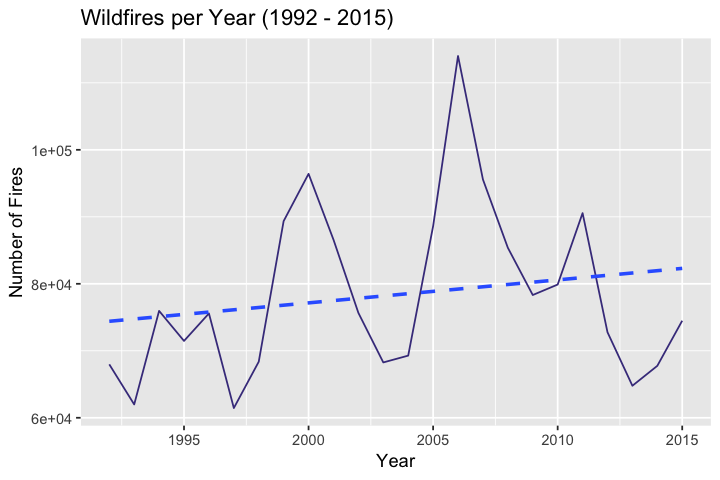

In [51]:
options(repr.plot.width=6, repr.plot.height=4, jupyter.plot_mimetypes = 'image/png')

fires %>% group_by(FIRE_YEAR) %>% summarize(n = n()) %>%
  ggplot(aes(x = FIRE_YEAR, y = n)) + geom_line(color = 'slateblue4') + 
  geom_smooth(method = 'lm', se = FALSE, linetype = 'dashed') + 
  labs(x = 'Year', y = 'Number of Fires', title = 'Wildfires per Year (1992 - 2015)')

**Fig 1.** Number of wild fire per year from 1992- 2015. There appears to be significant variability in the numbers of fires per year, though the variability appears to have a ~5 year period to it. This sub-decedal variability might be explained by large scale climatic forcing such as the Pacific Decadal Oscillation (PDO) though thats out of the scope of this project. Despite the variability there does appear to be positive trend in the number of fires per year. This increase in time is what we might expect in a warming climate, though we would a dataset with a longer timespan to really determine this relationship.

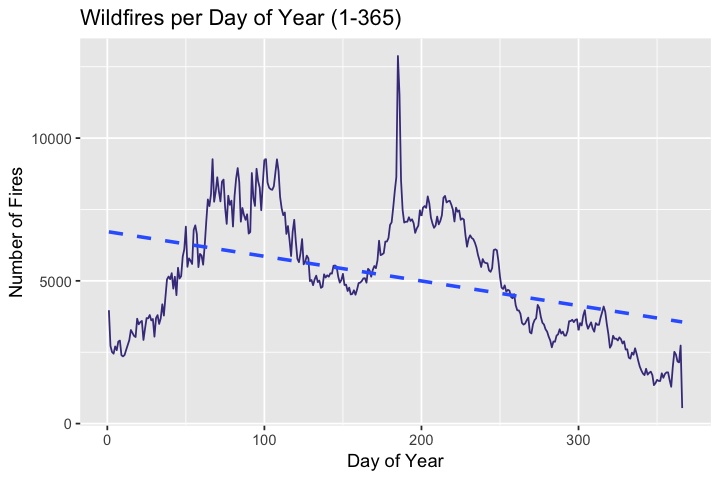

In [4]:
fires %>% group_by(DISCOVERY_DOY) %>% summarize(n = n()) %>%
  ggplot(aes(x = DISCOVERY_DOY, y = n)) + geom_line(color = 'slateblue4') + 
    geom_smooth(method = 'lm', se = FALSE, linetype = 'dashed') + 
      labs(x = 'Day of Year', y = 'Number of Fires', title = 'Wildfires per Day of Year (1-365)')

**Fig 2.** Number of wild fire per year calander day of year. A value of 1 would correspond to Jan 01 while a value of 365 would correspond to Dec 31st. In general there is a decrease in the number of fires per day throughout the year. There appears to be two seasonal maximums in the number of fires, the first occuring from 85 - 115 (~MAR) and the second from 180-220 (~June - July). The bimodal distribution is most likely due to different seasonal timings of the 'dry' season geographically throughout the U.S. 

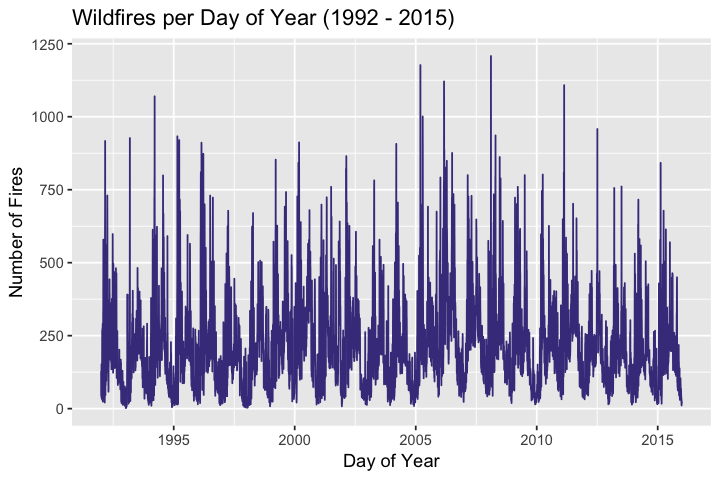

In [5]:
fires %>% mutate(date_ymd = as.Date(DISCOVERY_DATE - 2458598.5, origin = '2019-04-25')) %>%
  group_by(date_ymd) %>% summarise(n = n()) %>%  
    ggplot(aes(x = date_ymd, y = n)) + geom_line(color = 'slateblue4') + 
      labs(x = 'Day of Year', y = 'Number of Fires', title = 'Wildfires per Day of Year (1992 - 2015)')

**Fig 3.** Number of wildfires per day from 1992-2015. There appears to be a clear annual cyle in the number of fires supperimposed on the interannual variability. If were to do some spectral analysis on the data same we could asses the variability in a more complete way, but this is not within the scope of the project

In [54]:
fire_count <- fires %>% group_by(STAT_CAUSE_DESCR) %>% 
  summarize(n = n()) %>%
  ggplot(aes( x = reorder(STAT_CAUSE_DESCR, n), y = n)) + geom_bar(stat='identity', fill='slateblue4') + 
  coord_flip() + labs( x= '', y = 'Number of Fires', title = 'Count') + 
    ggsave("./figures/fire_count.png", width = 20, height = 10, units = "cm", dpi = 320)
burn_acres <- fires %>% group_by(STAT_CAUSE_DESCR) %>%
  summarize(n = mean(FIRE_SIZE, na.rm = TRUE)) %>%
  ggplot(aes( x = reorder(STAT_CAUSE_DESCR, n), y = n)) + geom_bar(stat='identity', fill='slateblue4') + 
  coord_flip() + labs( x= '', y = 'Burn Area (Acres)', title = 'Burn Area') + 
    ggsave("./figures/burn_acres.png", width = 20, height = 10, units = "cm", dpi = 320)

burn_time <- fires %>% group_by(STAT_CAUSE_DESCR) %>% mutate(BURN_TIME = CONT_DATE - DISCOVERY_DATE) %>%
  summarize(n = mean(BURN_TIME, na.rm = TRUE)) %>%
  ggplot( aes( x = reorder(STAT_CAUSE_DESCR, n), y = n)) + geom_bar(stat='identity', fill='slateblue4') + 
  coord_flip() + labs( x= '', y = 'Burn Time (days)', title = 'Burn Time ') + 
    ggsave("./figures/burn_turn.png", width = 20, height = 10, units = "cm", dpi = 320)

<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1">
<style>
body {font-family: Arial;}

/* Style the tab */
.tab {
  overflow: hidden;
  border: 1px solid #ccc;
  background-color: #f1f1f1;
}

/* Style the buttons inside the tab */
.tab button {
  background-color: inherit;
  float: left;
  border: none;
  outline: none;
  cursor: pointer;
  padding: 14px 16px;
  transition: 0.3s;
  font-size: 17px;
}

/* Change background color of buttons on hover */
.tab button:hover {
  background-color: #ddd;
}

/* Create an active/current tablink class */
.tab button.active {
  background-color: #ccc;
}

/* Style the tab content */
.tabcontent {
  display: none;
  padding: 6px 12px;
  border: 1px solid #ccc;
  border-top: none;
}
</style>
</head>
<body>

<h4 style="margin-bottom:5mm"> Investigation into destruction metrics for all 13 classes of fire cause. </h4>

<div class="tab">
  <button class="tablinks" onclick="openCity(event, 'Fire Count')" id="defaultOpen">Fire Count</button>
  <button class="tablinks" onclick="openCity(event, 'Burn Area')">Burn Area</button>
  <button class="tablinks" onclick="openCity(event, 'Burn Time')">Burn Time</button>
</div>

<div id="Fire Count" class="tabcontent">
   <img src="./figures/fire_count.png" alt="Fire Count per Cause" width="800" height="600"> 
    <p> <b>Fig. 4</b> Figure caption for the figure </p>
</div>

<div id="Burn Area" class="tabcontent">
  <img src="./figures/burn_acres.png" alt="Fire Count per Cause" width="800" height="600"> 
   <p> <b>Fig. 5</b> Figure caption for the figure </p>
</div>

<div id="Burn Time" class="tabcontent">
  <img src="./figures/burn_turn.png" alt="Fire Count per Cause" width="800" height="600"> 
    <p> <b>Fig. 6</b> Figure caption for the figure </p>
</div>

<script>
function openCity(evt, cityName) {
  var i, tabcontent, tablinks;
  tabcontent = document.getElementsByClassName("tabcontent");
  for (i = 0; i < tabcontent.length; i++) {
    tabcontent[i].style.display = "none";
  }
  tablinks = document.getElementsByClassName("tablinks");
  for (i = 0; i < tablinks.length; i++) {
    tablinks[i].className = tablinks[i].className.replace(" active", "");
  }
  document.getElementById(cityName).style.display = "block";
  evt.currentTarget.className += " active";
}

// Get the element with id="defaultOpen" and click on it
document.getElementById("defaultOpen").click();
</script>
   
</body>
</html> 


## Modeling <a class="anchor" id="modeling"></a>

First things first we are going to need to good way to visualize our results. Because we have a large multiclass classification problem, data visulization lends itself to a confusion matrix. I written a function that will plot a confusion matrix based on the examples from [Troy Walters kernel on Kaggle](https://www.kaggle.com/captcalculator/can-we-use-ml-to-predict-the-cause-of-a-wildfire).   

In [8]:
confusion_matrix <- function(predicted, validation){
  
table(validation, predicted) %>% prop.table(margin = 1) %>% as.data.frame.matrix() %>% 
    rownames_to_column(var = 'actual') %>% gather(key = 'prediction', value = 'freq',-actual) %>% replace_na(list(freq = 0)) %>%
    ggplot(aes(x = actual, y = prediction, fill = freq)) +
    geom_tile() + geom_text(aes(label = round(freq, 3)), size = 3, color = 'gray20') +
    scale_fill_gradient(low = 'orange', high = 'red', limits = c(0,1), name = 'Relative Frequency') +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    ggtitle('Confusion Matrix')

}

importance_plot <- function(fit, dataset, response){
  
  bagging_import <- tibble(
  var = dataset %>% select(-response) %>% names(), 
  import = c(fit$importance))

  ggplot(bagging_import, aes(x = reorder(var, import), y = import, fill = import)) +
    geom_bar(stat="identity", position="dodge")+ coord_flip() +
    ylab("Variable Importance")+
    xlab("") +
    guides(fill=F) +
    ggtitle("Information Value Summary")+
    scale_fill_continuous(low="lightblue", high="blue") + theme(plot.title = element_text(hjust = 0.5))
}

The original data set contains 1.88 million entires, which is too many to process on my personal machine. In order to efficently process that much data we would need to do our processing on multiple nodes of a high power computing resources, which is outside of the scope of this class. We will investiagte processing in parallel if and when possible, but for the bulk of this analysis this is outside the scope. Instead we are going to subset our data to 15% is orginal size (300,000 observations)


In [9]:
fires_no_nan <- fires %>% drop_na(STAT_CAUSE_DESCR, FIRE_YEAR, DISCOVERY_DOY, FIRE_SIZE, LATITUDE, LONGITUDE, BURN_TIME)

fires_no_nan <- fires_no_nan %>% select(STAT_CAUSE_DESCR, FIRE_YEAR, DISCOVERY_DOY, FIRE_SIZE, LATITUDE, LONGITUDE, BURN_TIME )

fires_no_nan <- fires_no_nan %>% mutate(STAT_CAUSE_DESCR = as_factor(STAT_CAUSE_DESCR))

set.seed(111)

subset_rp <- modelr::resample_partition(fires_no_nan, c(subset=0.05, nonused=0.95))

subset_fires_15 <- as_tibble(subset_rp$subset)

Splitting the data into training and testing sets.

In [10]:
set.seed(111)
rp <- modelr::resample_partition(subset_fires_15, c(train=0.7, test=0.3))
train_set15 <- as_tibble(rp$train)
test_set15 <- as_tibble(rp$test)

### A Simple tree approach <a class="anchor" id="tree"></a>

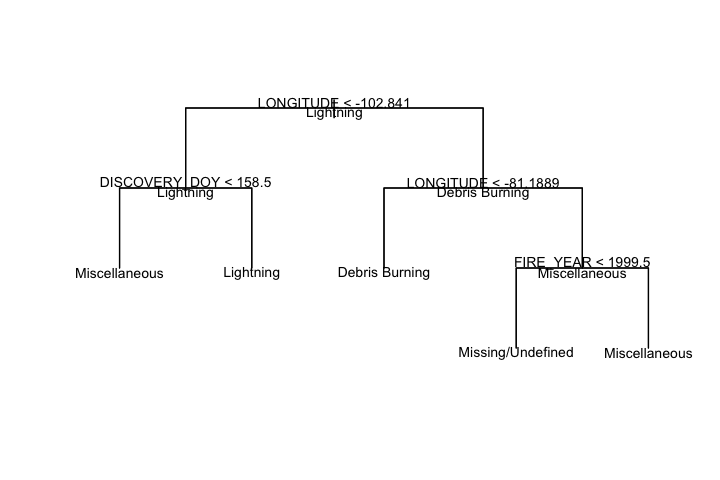

In [11]:
library(tree)
suppressMessages(library(tidymodels))
set.seed(111)

tree_fit <- tree(STAT_CAUSE_DESCR ~ ., data = train_set15)

plot(tree_fit, type = "uniform")
text(tree_fit, pretty = 1, all = TRUE, cex = 0.7)

# test_set15 %>% modelr::add_predictions(tree_fit, type = "class") %>%
#     accuracy(STAT_CAUSE_DESCR, predd

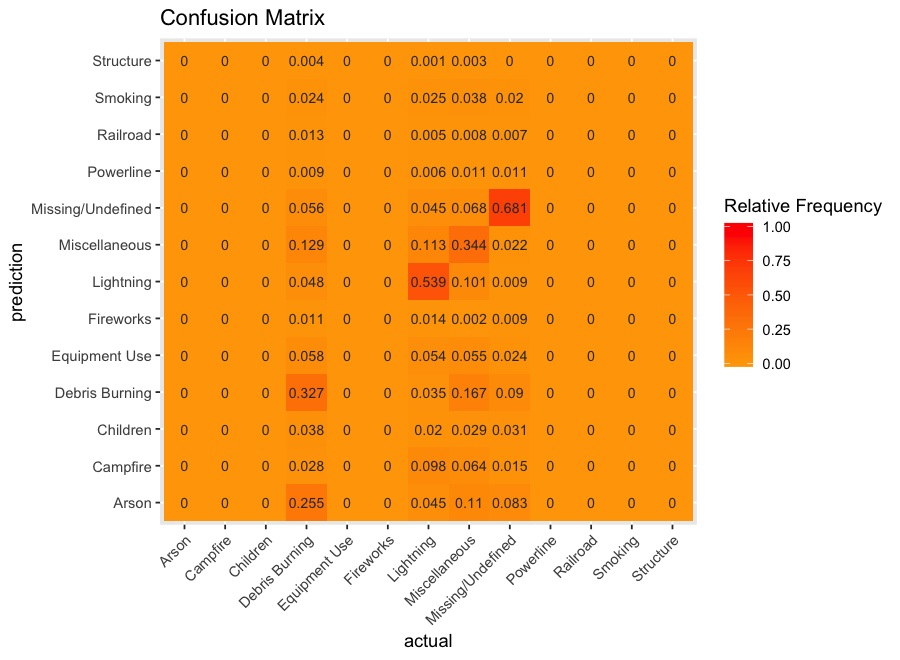

In [12]:
options(repr.plot.width=7.5, repr.plot.height=5.5, jupyter.plot_mimetypes = 'image/png')

tree_pred <- test_set15 %>% modelr::add_predictions(tree_fit, type = "class", var = 'EstCODE')
confusion_matrix(tree_pred$STAT_CAUSE_DESCR, tree_pred$EstCODE) 

### Bagging <a class="anchor" id="bagging"></a>


[1] 0.4429689

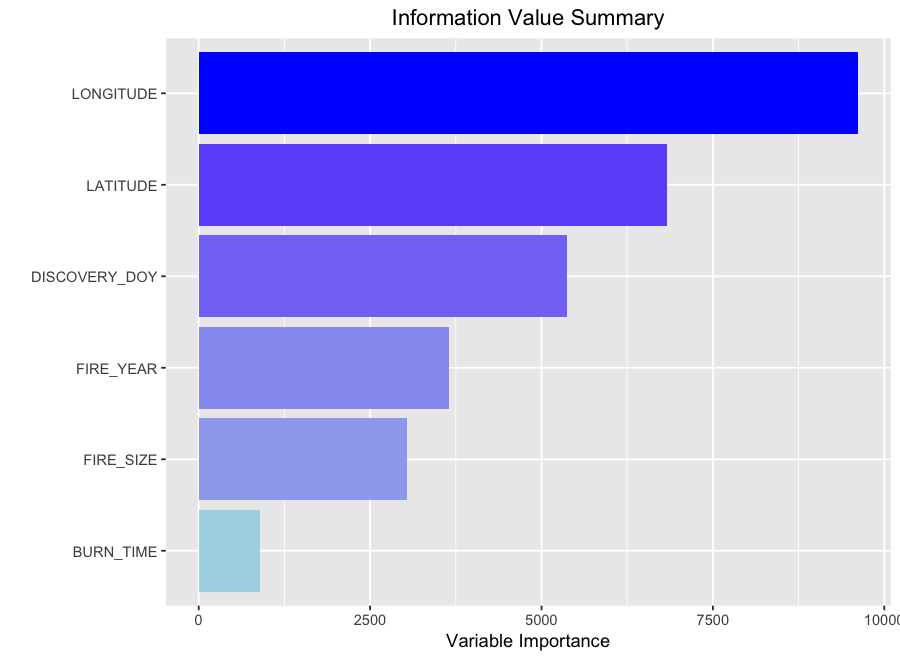

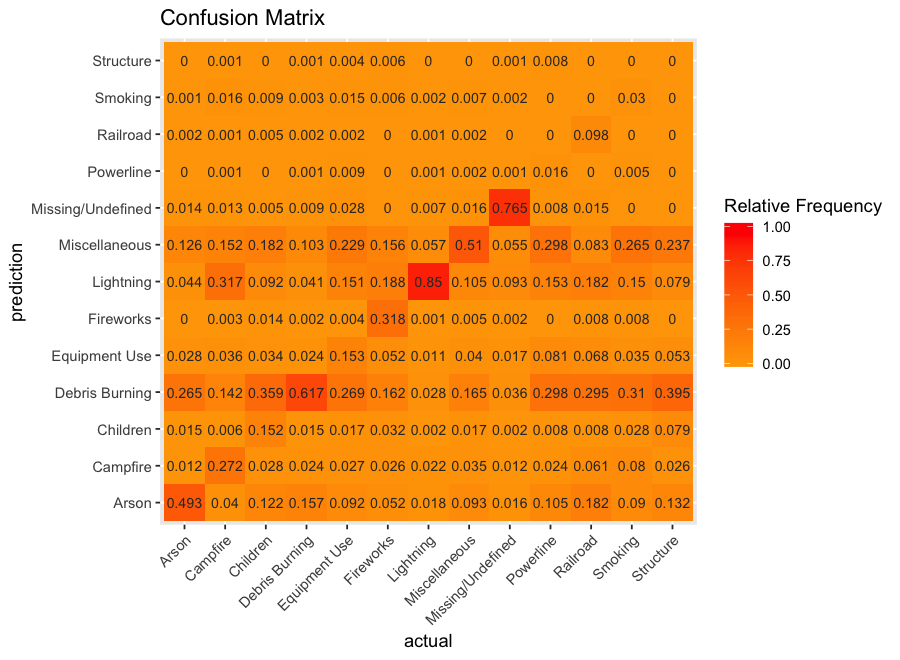

In [13]:
suppressMessages(library(randomForest))

set.seed(111)

bagging_fit <- randomForest(STAT_CAUSE_DESCR~., train_set15, mtry = 6)
bagging_pred <- test_set15 %>% mutate(EstCODE = predict(bagging_fit, test_set15, type = 'class'))

#Calculate the test error rate
mean(test_set15$STAT_CAUSE_DESCR != bagging_pred$EstCODE)

importance_plot(fit = bagging_fit, dataset = train_set15, response = 'STAT_CAUSE_DESCR')

confusion_matrix(validation = bagging_pred$STAT_CAUSE_DESCR, predicted = bagging_pred$EstCODE )

In [14]:
rf_pred %>% count(STAT_CAUSE_DESCR, EstCODE) %>% spread(STAT_CAUSE_DESCR,n) %>% prop.table(margin = 1) %>% as.data.frame.matrix()

ERROR: Error in eval(lhs, parent, parent): object 'rf_pred' not found


### Random Forest <a class="anchor" id="forest"></a>

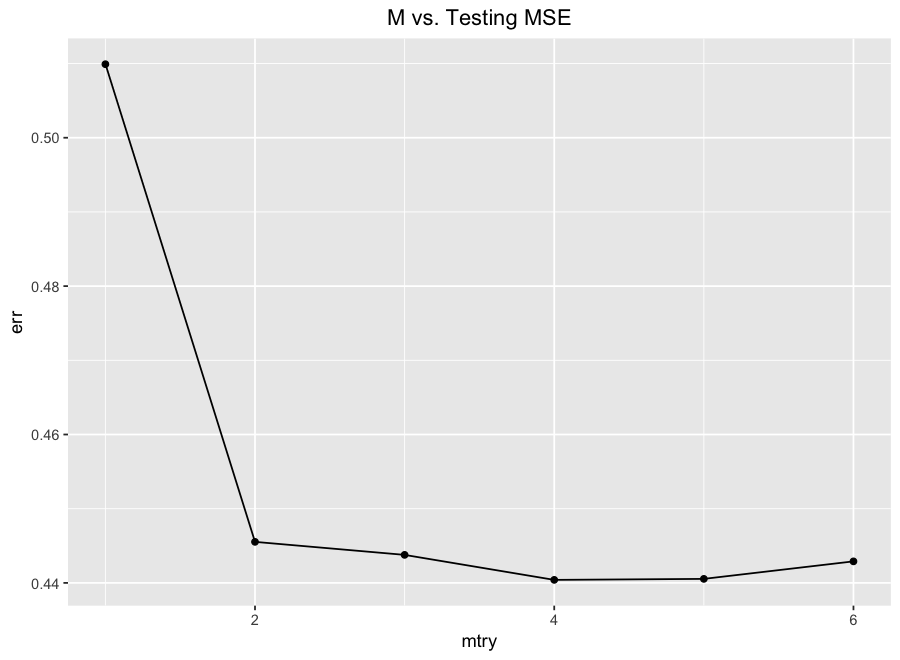

In [15]:
set.seed(111)

forest_mtry <- tibble(mtry = numeric(), err=numeric())

for (i in seq(1, 6,1)){
  rand_for_fit <- randomForest(STAT_CAUSE_DESCR ~., data = train_set15, mtry = i)
  rand_for_pred <- test_set15 %>% mutate(EstCODE = predict(rand_for_fit, test_set15, type = 'class'))
  err <- mean(rand_for_pred$STAT_CAUSE_DESCR != rand_for_pred$EstCODE)
  forest_mtry <- add_row(forest_mtry, mtry = i, err = err)
}

ggplot(forest_mtry, aes(x = mtry , y = err)) + 
  geom_point() + geom_line() + 
  ggtitle("M vs. Testing MSE") + theme(plot.title = element_text(hjust = 0.5))

[1] 0.4398679

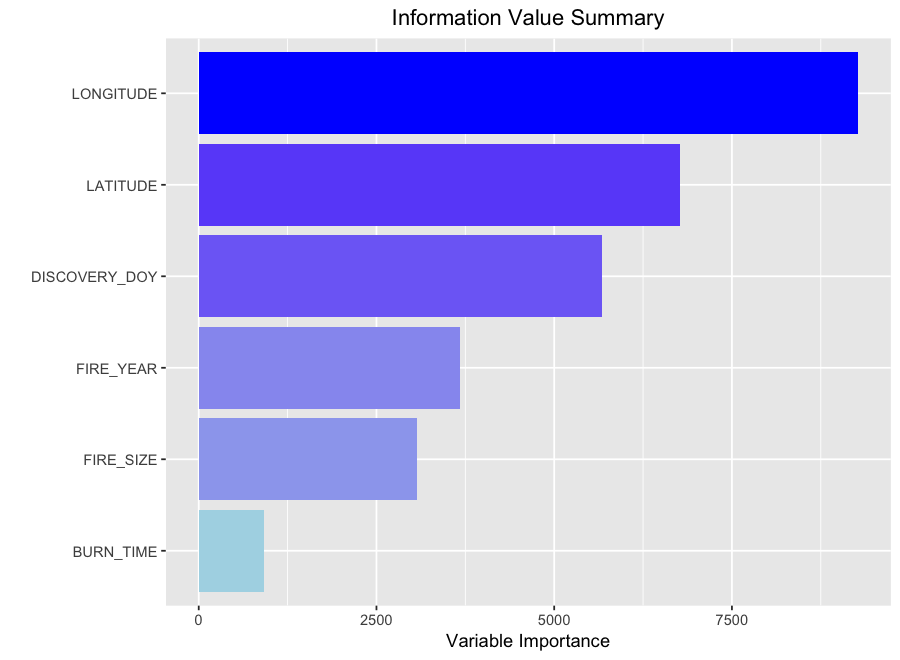

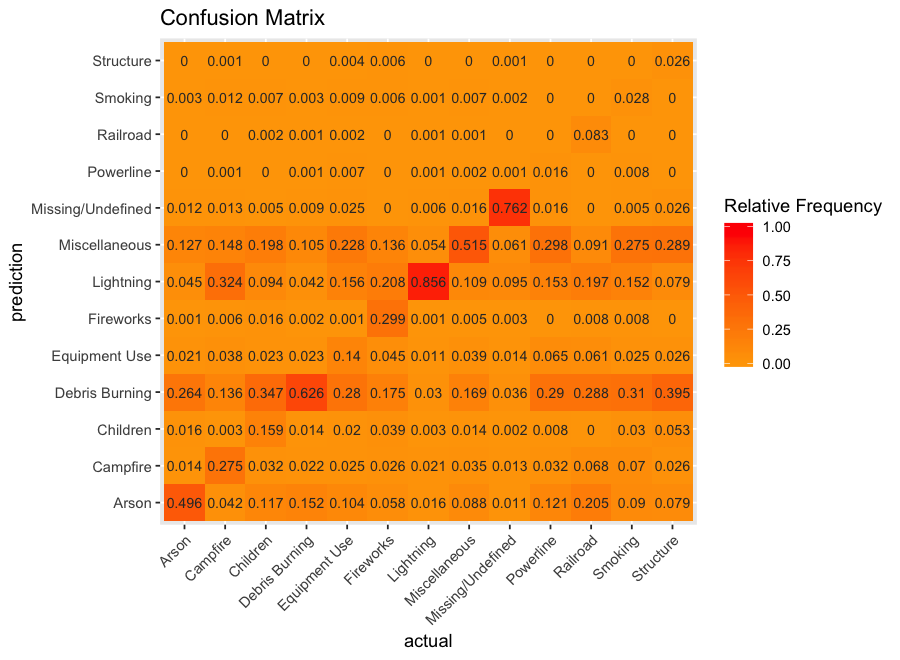

In [16]:
rand_for_fit <- randomForest(STAT_CAUSE_DESCR ~., data = train_set15, mtry = 4)

importance_plot(fit = rand_for_fit, dataset = train_set15, response = 'STAT_CAUSE_DESCR')

rand_for_pred <- test_set15 %>% mutate(EstCODE = predict(rand_for_fit, test_set15, type = 'class'))

#Calculate the test error rate
mean(test_set15$STAT_CAUSE_DESCR != rand_for_pred$EstCODE)

confusion_matrix(validation = rand_for_pred$STAT_CAUSE_DESCR, predicted = rand_for_pred$EstCODE )

### Boosting <a class="anchor" id="boosting"></a>

[1] "Test error using boosting = 0.930901981933396"


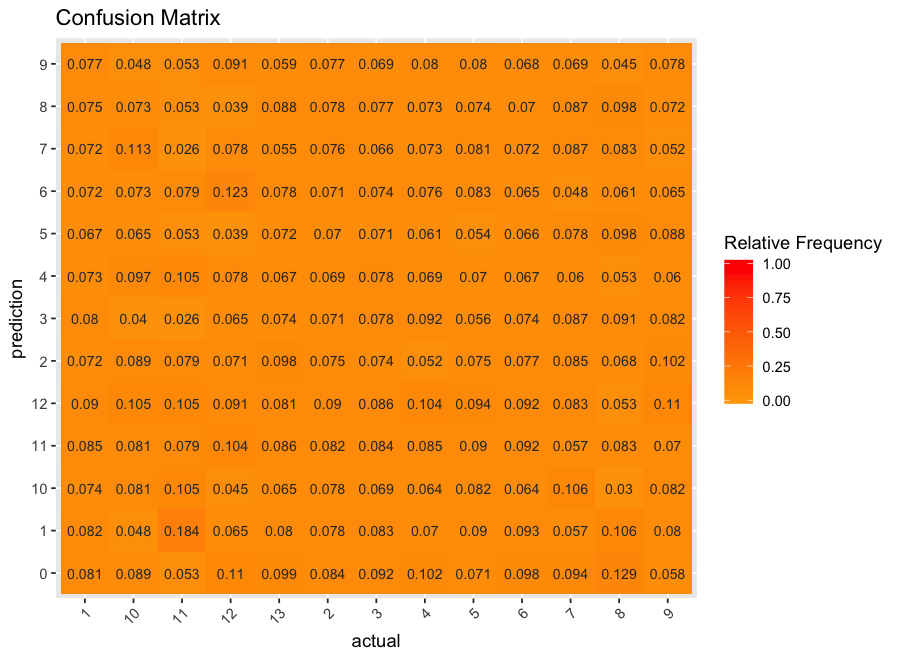

In [18]:
set.seed(111)
suppressMessages(library(gbm))

boost_fit <- gbm(STAT_CAUSE_DESCR ~ ., data= train_set15, n.tree = 100, distribution = 'multinomial', n.cores = 4)
boost_pred <- predict(boost_fit, test_set15, n.trees = 100, type = 'response') %>% matrix(., ncol = 13, byrow = TRUE) %>% apply(., 1, which.max) - 1L 

print(paste("Test error using boosting =", mean(boost_pred !=  test_set15$STAT_CAUSE_DESCR %>% as.numeric())))

confusion_matrix(predicted = boost_pred, validation = test_set15$STAT_CAUSE_DESCR %>% as.numeric())


### Extereme Gradient Boosting <a class="anchor" id="xgboost"></a>

[1]	train-merror:0.475615	test-merror:0.493259 
[2]	train-merror:0.459436	test-merror:0.479102 
[3]	train-merror:0.453744	test-merror:0.475057 
[4]	train-merror:0.449035	test-merror:0.470743 
[5]	train-merror:0.444095	test-merror:0.467777 
[6]	train-merror:0.439038	test-merror:0.464136 
[7]	train-merror:0.433751	test-merror:0.460698 
[8]	train-merror:0.430573	test-merror:0.458878 
[9]	train-merror:0.427366	test-merror:0.458272 
[10]	train-merror:0.424217	test-merror:0.456991 
[11]	train-merror:0.420837	test-merror:0.455710 
[12]	train-merror:0.418323	test-merror:0.454968 
[13]	train-merror:0.416156	test-merror:0.454294 
[14]	train-merror:0.412227	test-merror:0.454025 
[15]	train-merror:0.409338	test-merror:0.452002 
[16]	train-merror:0.407575	test-merror:0.450586 
[17]	train-merror:0.404917	test-merror:0.449980 
[18]	train-merror:0.402259	test-merror:0.448429 
[19]	train-merror:0.400035	test-merror:0.448025 
[20]	train-merror:0.397550	test-merror:0.448092 
[21]	train-merror:0.394545	te

[1] "Test error using softmax = 0.450182014291493"


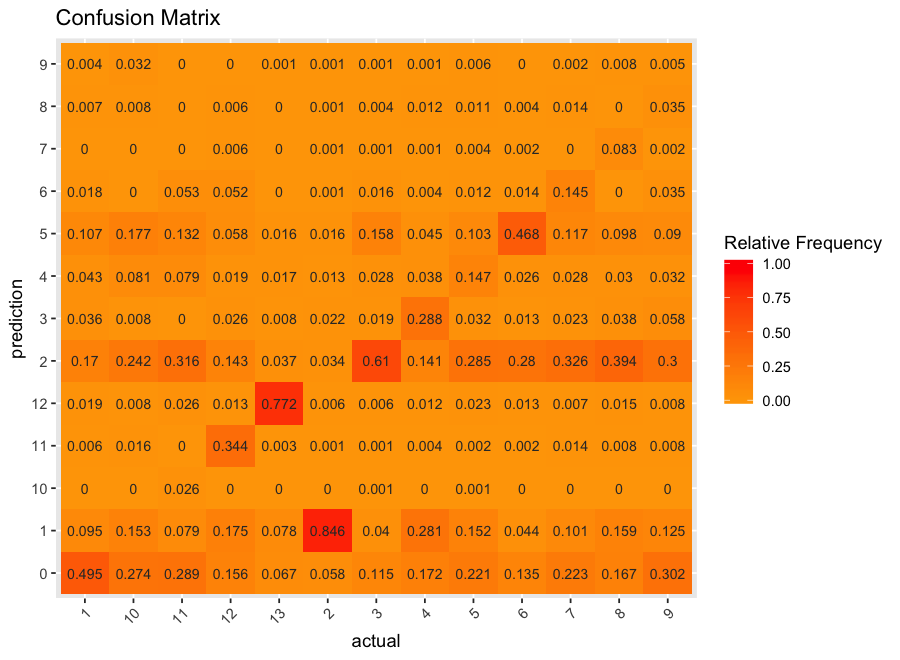

In [20]:
set.seed(111)
suppressMessages(library(xgboost))

xg_train <- xgb.DMatrix(data = as.matrix(train_set15 %>% select(-STAT_CAUSE_DESCR)), label = train_set15$STAT_CAUSE_DESCR %>% as.numeric() - 1L)

xg_test <- xgb.DMatrix(data = as.matrix(test_set15 %>% select(-STAT_CAUSE_DESCR)), label = test_set15$STAT_CAUSE_DESCR %>% as.numeric() - 1L)

params <- list(
  objective = 'multi:softmax',
  num_class = 13,
  nthread = 4
)

watchlist = list(train = xg_train, test = xg_test)

xgboost_fit <- xgb.train(
  params = params,
  data = xg_train,
  watchlist = watchlist,
  nrounds = 1000
)

pred <- predict(xgboost_fit, xg_test)
error_rate <- sum(pred != test_set15$STAT_CAUSE_DESCR %>% as.numeric() - 1L) / length(test_set15$STAT_CAUSE_DESCR %>% as.numeric())
print(paste("Test error using softmax =", error_rate))

confusion_matrix(predicted = pred, validation = test_set15$STAT_CAUSE_DESCR %>% as.numeric())

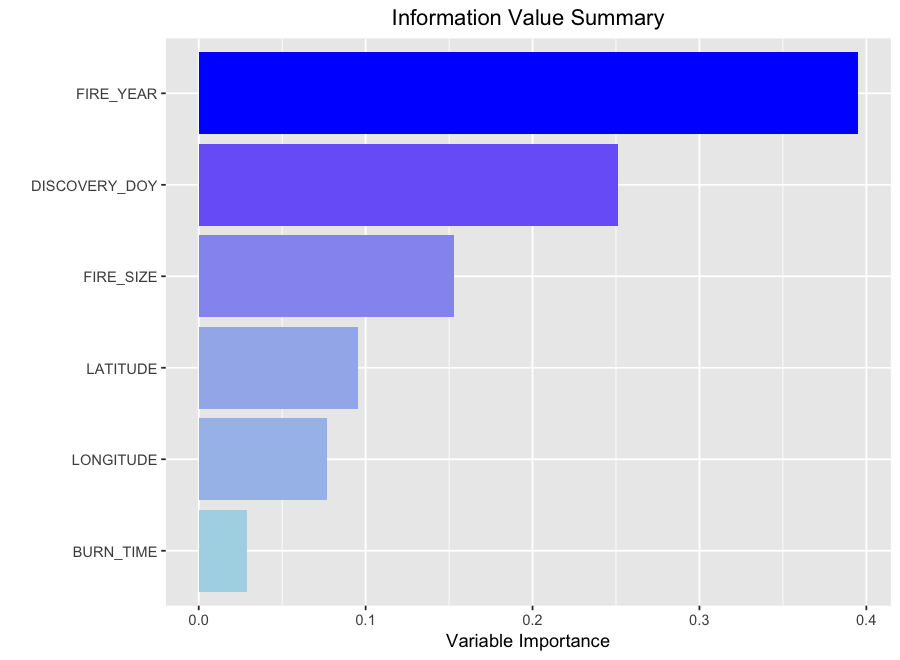

In [44]:
imp = xgb.importance(model = xgboost_fit)

bagging_import <- tibble(
  var = train_set15 %>% select(-STAT_CAUSE_DESCR) %>% names(), 
  import = c(imp$Importance))

  ggplot(bagging_import, aes(x = reorder(var, import), y = import, fill = import)) +
    geom_bar(stat="identity", position="dodge")+ coord_flip() +
    ylab("Variable Importance")+
    xlab("") +
    guides(fill=F) +
    ggtitle("Information Value Summary")+
    scale_fill_continuous(low="lightblue", high="blue") + theme(plot.title = element_text(hjust = 0.5))

### Support Vector Machines  <a class="anchor" id="SVM"></a>

[1] 0.5304031

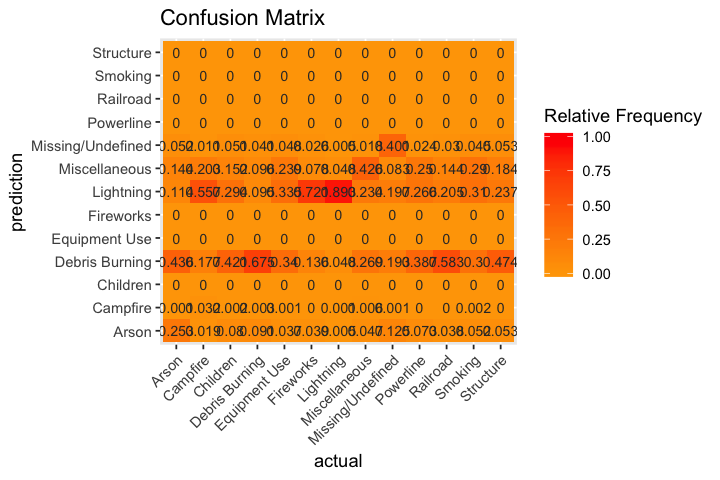

In [50]:
suppressMessages(library(e1071))

svm_fit <- svm(STAT_CAUSE_DESCR ~ ., train_set15)

svm_predict <- test_set15 %>% mutate(EstCODE = predict(svm_fit, test_set15))

mean(svm_predict$EstCODE != svm_predict$STAT_CAUSE_DESCR)

confusion_matrix(predicted = svm_predict$EstCODE, validation = svm_predict$STAT_CAUSE_DESCR)